Data Science + Social Justice<br>
Network Analysis <br>
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk)

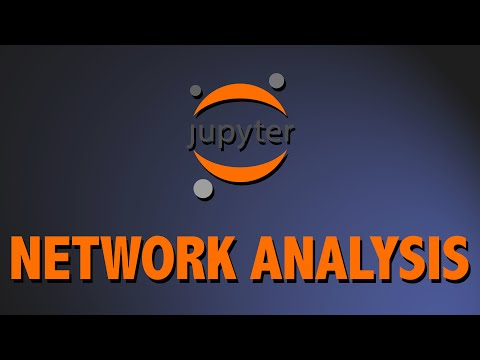

In [1]:
# Please run this cell for the accompanying video.
from IPython.display import YouTubeVideo
YouTubeVideo('wVsyPmWFK9o', width=640, height=360)

# Network Analysis

In this notebook, we'll access the Reddit API to do a small network analysis of "influencers" in our data. First, you will need to sign up with Reddit to run some of the code.

### 1. Sign up

Go to http://www.reddit.com and **sign up** for an account.

### 2. Create an app
Go to https://ssl.reddit.com/prefs/apps/ and click on `create app`:

### 3. Note details 
Note the client ID, client secret, and your username/password for Reddit, as you'll need them here.

client_id:
The client ID is at least a 14-character string listed just under “personal use script” for the desired developed application

client_secret:
The client secret is at least a 27-character string listed adjacent to secret for the application.

password:
The password for the Reddit account used to register the application.

username:
The username of the Reddit account used to register the application.

<img src="../../Img/reddit-API.png" alt="Drawing" style="width: 700px;"/>



In [1]:
import praw

reddit = praw.Reddit(client_id='YOUR_CLIENT_ID_HERE',
                     client_secret='YOUR_CLIENT_SECRET_HERE',
                     password='YOUR_REDDIT_PSW_HERE',
                     user_agent='Get Reddit network data, v1.0, by /u/YOUR_USERNAME_HERE',
                     username='YOUR_USERNAME_HERE')

## Network analysis: finding influencers in Reddit data

When getting Reddit data, one cannot at a glance see which users are influential. Other social media platforms have follower counts which directly quantify the amount of reach a user is likely to have, while redditors only have karma, i.e., the net total up and down votes since account creation, and a log of their posts and comments in different subreddits. These twose statistics can give a rough idea of a user’s activity.

It has already been found that a very small percentage of Reddit’s users create the vast majority of the site’s content, so we would not be surprised if only a few users could influence the discourse of entire subreddits. Identifying these users would help us understand how a subreddit's discourse is shaped. 

In [2]:
import os
# We include two ../ because we want to go two levels up in the file structure
os.chdir('../../Data')

In [4]:
import pandas as pd
df = pd.read_csv('aita_sub_top_sm.csv')

Let's sort by score and just get the top 1000 posts.

In [5]:
df = df.sort_values(by='score',ascending=False)[:1000]

In [6]:
df.author.count()

1000

How many unique authors do we have in our data?

In [7]:
df.author.nunique()

975

<AxesSubplot:xlabel='score', ylabel='num_comments'>

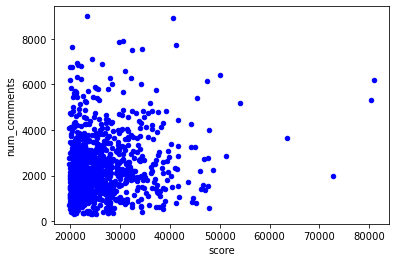

In [8]:
df.plot('score', 'num_comments', kind='scatter', color='blue')

Note that this scatter plot shows that the number of comments don’t necessarily increase with posts that have a higher net score.

In [9]:
repeating = df[df.duplicated(['author'], keep = False)] # Only take users who posted more than once

In [10]:
repeating = repeating[repeating.author != 'None'] # Get rid of deleted users

In [11]:
repeating.author.nunique() # Out of all posts, this is the amount of people who posted more than once 

25

Next, we need to decide which of these users we consider to be "influencers". Let's first have a look at how often these popular authors are posting.

[Text(0.5, 0, 'Authors'), Text(0, 0.5, 'Number of posts')]

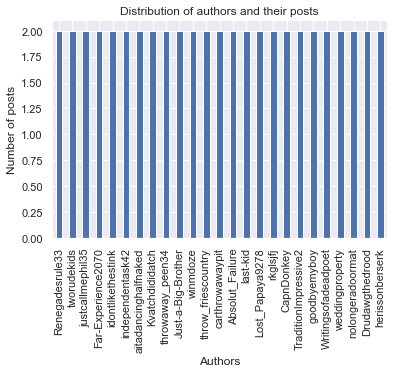

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# See the distrubution of authors and their posts
ax = repeating.author.value_counts().plot(kind='bar',title='Distribution of authors and their posts') 
ax.set(xlabel="Authors", ylabel="Number of posts")

Deciding who is an "influencer" of course has to do with the size of the subreddit and how often submissions are made.

In [13]:
u_authors = list(repeating.author.unique()) 

In [14]:
u_authors[:5]

['Renegadesrule33',
 'Absolut_Failure',
 'Drudawgthedrood',
 'nolongeradoormat',
 'weddingproperty']

Let's define a function that can get us the other posts by the influencers we have found in our data.

In [15]:
def get_user_posts(author, n):
    try:
        redditor = reddit.redditor(author)
        user_posts_list = []
        for submission in redditor.submissions.top(limit = n):
            info_list = []
            info_list.append(submission.id)
            info_list.append(submission.score)
            info_list.append(str(submission.author))
            info_list.append(submission.num_comments)
            info_list.append(str(submission.subreddit))
            user_posts_list.append(info_list)
    # Dealing with errors in case redditors have been banned, deleted their accounts, etc.
    except:
        pass

    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df

In [16]:
authors_df =  pd.DataFrame() # Makes an empty dataframe
authors_df = authors_df.fillna(0)
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [17]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [18]:
authors_df.head(10) # Dataframe of other subreddits where authors posted 

,id,score,author,num_comments,subreddit
0,azvko1,72777,Renegadesrule33,1988,AmItheAsshole
1,awyi8k,46800,Renegadesrule33,2706,AmItheAsshole
0,opgizn,48913,Absolut_Failure,2237,AmItheAsshole
1,onxses,37444,Absolut_Failure,5744,AmItheAsshole
2,onxco8,1643,Absolut_Failure,144,badwomensanatomy
3,oknvw6,983,Absolut_Failure,254,IsItBullshit
4,op9kt3,2,Absolut_Failure,1,AmItheAsshole
0,i1bxoe,47900,Drudawgthedrood,597,AmItheAsshole
1,gflupe,30131,Drudawgthedrood,2047,AmItheAsshole
2,l97vq1,135,Drudawgthedrood,30,TalesFromTheFrontDesk


Next, let's find out where else these influencers posted. We'll compile a list of authors that appeared more than once on other subreddits. In order to form a network graph, we need data about the particular subreddits where our influencers appeared. For the sake of simplicity, we visualized those subreddits with at least 2 or more posts made by the influencers. The Y-axis is the number of submissions and the X-axis are the respective subreddits.

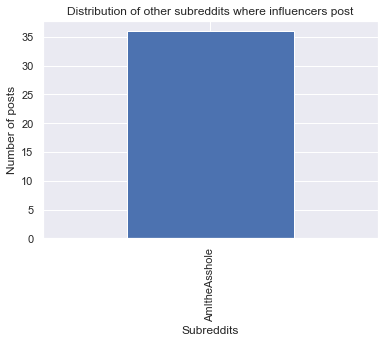

In [19]:
counts = authors_df['subreddit'].value_counts() 

# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 10].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

# Network Analysis

## Initial approach

In [20]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head()

,author,subreddit
0,Renegadesrule33,AmItheAsshole
1,Renegadesrule33,AmItheAsshole
0,Absolut_Failure,AmItheAsshole
1,Absolut_Failure,AmItheAsshole
2,Absolut_Failure,badwomensanatomy


In [21]:
n_df.to_csv('aita_edges')

## Visualize using NetworkX

In [22]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 
auths = list(n_df.author.unique()) # Make list of unique authors to use in network graph 

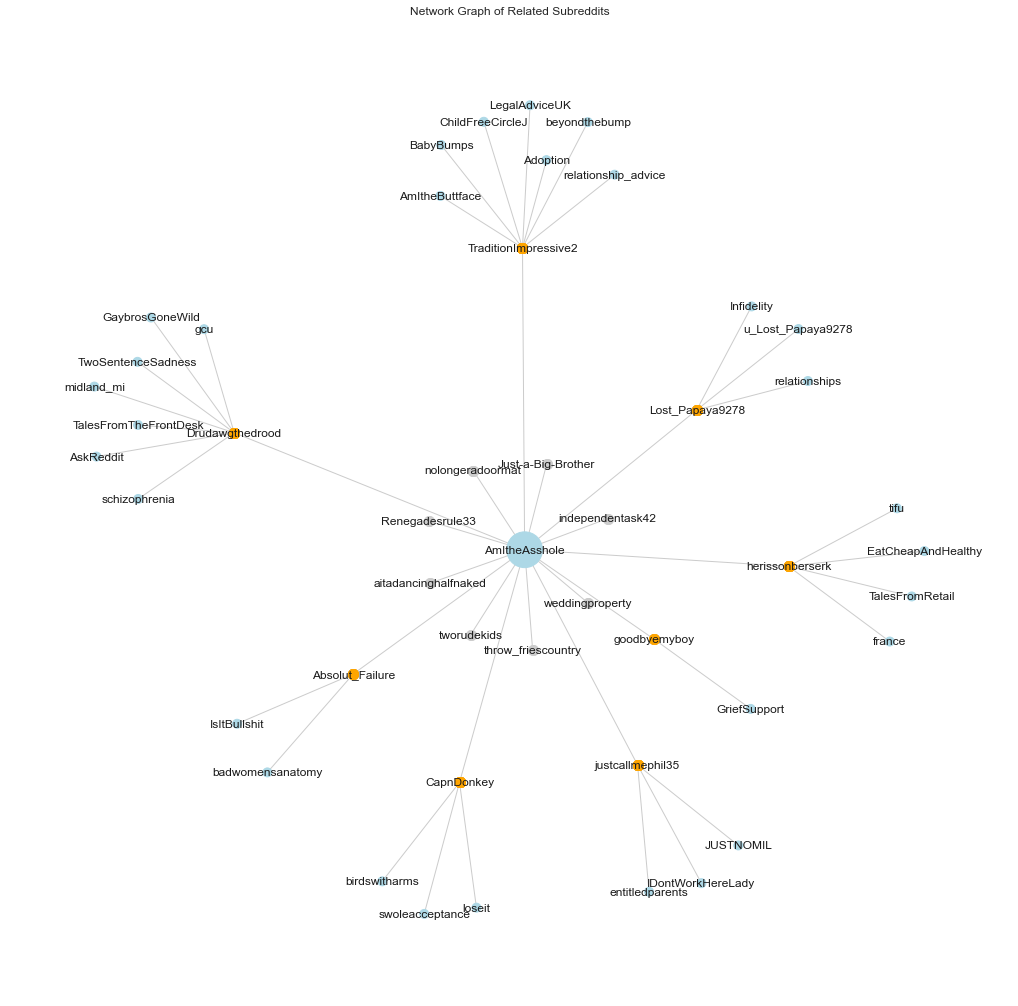

In [23]:
import networkx as nx

plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=authors_df['author'], node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
influencers = [person for person in authors_df['author'] if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=influencers, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
auth_labels = dict(zip(auths, auths)) #labels for authors

nx.draw_networkx_labels(g, layout, labels=node_labels)
nx.draw_networkx_labels(g, layout, labels=auth_labels)


# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

### Interpreting the graph
In this graph, influencer nodes appear small and grey. The influencers who have more connections than just r/amitheasshole are highlighted in yellow. The subreddits appear in blue and sized according to their respective number of connections.